In [1]:
import pandas as pd
import re
import nltk
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

2024-05-04 06:42:10.119831: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-05-04 06:42:10.120078: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-05-04 06:42:10.121936: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-05-04 06:42:10.144737: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI AVX512_BF16 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-04 06:42:10.784425: W tensorflow/compiler/tf2tensorrt/utils/py_uti

In [2]:
# from google.colab import drive
# drive.mount('/content/drive', force_remount=True)

In [3]:
# # Loading the dataset (using the downloaded file)
# path = "/content/drive/MyDrive/Colab Notebooks/DATA255_Assignment/IMDB_Dataset.csv"
# df = pd.read_csv(path)

In [4]:
df= pd.read_csv("IMDB_Dataset.csv")
df.head()

,review,sentiment
0,Once again Mr. Costner has dragged out a movie...,0
1,This is an example of why the majority of acti...,0
2,"First of all I hate those moronic rappers, who...",0
3,Not even the Beatles could write songs everyon...,0
4,Brass pictures (movies is not a fitting word f...,0


In [5]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [6]:
##cleaning up the text
stopWords = set(nltk.corpus.stopwords.words("english"))
def CleanText(text):
    text = text.lower()
    text = re.sub("[^a-z]", " ", text)
    words = [word for word in text.split() if word not in stopWords]
    text = " ".join(words)
    return text

df["review"]=df.apply(lambda row: CleanText(row["review"]), axis=1)
Data = df.review
labels = df.sentiment

In [7]:
### converting 1000 most frequent words to integer
frequentWord = 10000
tokenizer = Tokenizer(num_words=frequentWord)

tokenizer.fit_on_texts(Data)

IntegerizedData = pd.Series(tokenizer.texts_to_sequences(Data))
IntegerizedData.head()

0    [315, 6873, 3237, 2, 117, 996, 1569, 1033, 117...
1    [342, 2080, 100, 30, 3711, 232, 11, 66, 165, 5...
2    [20, 595, 4986, 24, 8579, 369, 844, 7247, 2536...
3    [8, 5767, 24, 749, 582, 180, 304, 147, 2329, 2...
4    [8836, 1155, 25, 3325, 521, 11, 535, 9224, 920...
dtype: object

In [8]:
### You can convert the sequences back to the string
tokenizer.sequences_to_texts(IntegerizedData[0:1])

['mr costner dragged movie far longer necessary aside terrific sea rescue sequences care characters us ghosts closet costner character realized early forgotten much later time care character really care cocky ashton kutcher problem comes kid thinks better anyone else around shows signs closet appears winning costner finally well past half way point stinker costner tells us kutcher ghosts told kutcher driven best prior magic could keep turning hour']

In [9]:
DataLength=IntegerizedData.apply(lambda x: len(x))
DataLength.describe()

count    50000.000000
mean       110.157100
std         81.213625
min          3.000000
25%         60.000000
50%         83.000000
75%        135.000000
max       1104.000000
dtype: float64

The average length of reviews is 110, the shortest review length is 3 and the longest is 1104.

Therefore we need to pad the sequences to equal length.

The following padding function performs zero padding if the length of a sequence is less than the threshold and truncate the ones which are longer than threshold to the threshold.  We choose the threshold to be 256.

In [10]:
#zero padding
IntegerizedData= pad_sequences(IntegerizedData, maxlen=256)


In [11]:
IntegerizedData

array([[   0,    0,    0, ...,  269, 1456,  397],
       [   0,    0,    0, ...,  363,    3,   80],
       [   0,    0,    0, ...,   54,   57,   76],
       ...,
       [   0,    0,    0, ...,  973,   99, 9907],
       [   0,    0,    0, ..., 8508, 3506,   13],
       [   0,    0,    0, ...,   11, 2263,   23]], dtype=int32)

In [12]:
x_train_val,x_test,y_train_val,y_test = train_test_split(IntegerizedData,labels,stratify=labels,test_size=0.20, random_state=42)
x_train,x_val,y_train,y_val = train_test_split(x_train_val,y_train_val,stratify=y_train_val,test_size=0.10, random_state=42)

In [13]:
type(x_val)

numpy.ndarray

In [14]:
print(y_train.shape,y_val.shape,y_test.shape)

(36000,) (4000,) (10000,)


## now you have your training, validation and test set as numpy arrays, you can implement the networks

In [15]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import TensorDataset
import tensorflow as tf
import torch
from torch.utils.data import TensorDataset, DataLoader
import time

In [16]:
# Define the neural network architecture
class RNNClassifier_b(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim):
        super(RNNClassifier_b, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.rnn = nn.RNN(embedding_dim, hidden_dim, batch_first=True)
        self.fc1 = nn.Linear(hidden_dim, 16)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(16, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        embedded = self.embedding(x)
        rnn_out, _ = self.rnn(embedded)
        max_pool_out, _ = torch.max(rnn_out, 1)
        fc1_out = self.relu(self.fc1(max_pool_out))
        output = self.sigmoid(self.fc2(fc1_out))
        return output.squeeze(1)

# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Epoch 1/80, Time: 4.16s, Train Loss: 0.5518, Val Loss: 0.3926, Train Accuracy: 0.6880, Val Accuracy: 0.8133
Epoch 2/80, Time: 6.17s, Train Loss: 0.3331, Val Loss: 0.3389, Train Accuracy: 0.8580, Val Accuracy: 0.8468
Epoch 3/80, Time: 3.63s, Train Loss: 0.2648, Val Loss: 0.2996, Train Accuracy: 0.8914, Val Accuracy: 0.8632
Epoch 4/80, Time: 3.62s, Train Loss: 0.2171, Val Loss: 0.3022, Train Accuracy: 0.9160, Val Accuracy: 0.8702
Epoch 5/80, Time: 3.76s, Train Loss: 0.1819, Val Loss: 0.3085, Train Accuracy: 0.9301, Val Accuracy: 0.8720
Epoch 6/80, Time: 3.73s, Train Loss: 0.1450, Val Loss: 0.3436, Train Accuracy: 0.9479, Val Accuracy: 0.8732
Epoch 7/80, Time: 3.65s, Train Loss: 0.1139, Val Loss: 0.3673, Train Accuracy: 0.9621, Val Accuracy: 0.8682
Epoch 8/80, Time: 3.65s, Train Loss: 0.0874, Val Loss: 0.3899, Train Accuracy: 0.9724, Val Accuracy: 0.8732
Epoch 9/80, Time: 3.68s, Train Loss: 0.0628, Val Loss: 0.4109, Train Accuracy: 0.9824, Val Accuracy: 0.8715
Epoch 10/80, Time: 3.70s, Tr

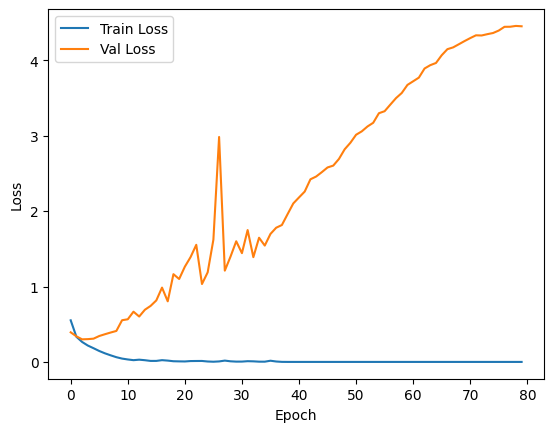

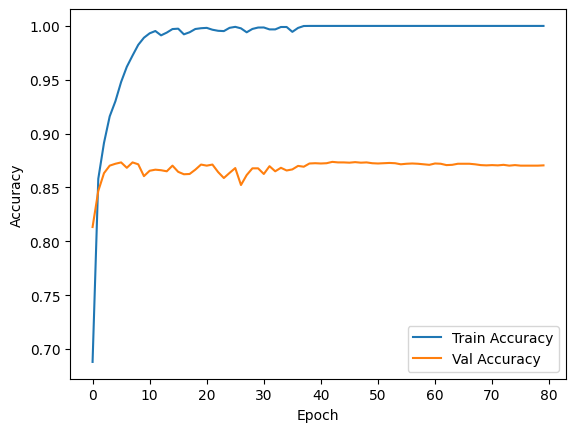

Test Accuracy: 0.8679


In [17]:
# Convert data to PyTorch tensors and move to GPU if available
x_train_tensor = torch.tensor(x_train).long().to(device)
y_train_tensor = torch.tensor(y_train.values).float().to(device)
x_val_tensor = torch.tensor(x_val).long().to(device)
y_val_tensor = torch.tensor(y_val.values).float().to(device)
x_test_tensor = torch.tensor(x_test).long().to(device)

# Create DataLoader for training and validation sets
train_dataset = TensorDataset(x_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_dataset = TensorDataset(x_val_tensor, y_val_tensor)
val_loader = DataLoader(val_dataset, batch_size=64)

# Hyperparameters
embedding_dim = 64
hidden_dim = 64
learning_rate = 0.001
num_epochs = 80

# Instantiate the model and move it to GPU if available
model = RNNClassifier_b(frequentWord, embedding_dim, hidden_dim).to(device)

# Define loss function and optimizer
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Training loop
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

for epoch in range(num_epochs):
    start_time = time.time()  # Record start time for the epoch

    model.train()
    train_loss = 0.0
    correct_train = 0
    total_train = 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)  # Move batch to GPU
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * inputs.size(0)

        predicted = torch.round(outputs)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    train_loss /= len(train_loader.dataset)
    train_losses.append(train_loss)
    train_accuracy = correct_train / total_train
    train_accuracies.append(train_accuracy)

    model.eval()
    val_loss = 0.0
    correct_val = 0
    total_val = 0

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)  # Move batch to GPU
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * inputs.size(0)

            predicted = torch.round(outputs)
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()

    val_loss /= len(val_loader.dataset)
    val_losses.append(val_loss)
    val_accuracy = correct_val / total_val
    val_accuracies.append(val_accuracy)

    epoch_time = time.time() - start_time  # Calculate time taken for the epoch
    print(f'Epoch {epoch+1}/{num_epochs}, Time: {epoch_time:.2f}s, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, Val Accuracy: {val_accuracy:.4f}')

# Plotting train and validation losses
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plotting train and validation accuracies
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(val_accuracies, label='Val Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Evaluation on test set
model.eval()
with torch.no_grad():
    outputs = model(x_test_tensor)
    y_pred = torch.round(outputs).cpu().numpy()  # Move predictions to CPU for numpy conversion

# Calculate test accuracy
test_accuracy = np.mean(y_pred == y_test.values)
print(f'Test Accuracy: {test_accuracy:.4f}')

## Changing the batch size to 512

Epoch 1/80, Time: 4.74s, Train Loss: 0.6941, Val Loss: 0.6926, Train Accuracy: 0.5076, Val Accuracy: 0.5302
Epoch 2/80, Time: 0.41s, Train Loss: 0.6922, Val Loss: 0.6918, Train Accuracy: 0.5250, Val Accuracy: 0.5603
Epoch 3/80, Time: 4.02s, Train Loss: 0.6913, Val Loss: 0.6910, Train Accuracy: 0.5743, Val Accuracy: 0.5747
Epoch 4/80, Time: 0.41s, Train Loss: 0.6902, Val Loss: 0.6899, Train Accuracy: 0.5542, Val Accuracy: 0.5720
Epoch 5/80, Time: 0.39s, Train Loss: 0.6888, Val Loss: 0.6882, Train Accuracy: 0.6352, Val Accuracy: 0.6670
Epoch 6/80, Time: 3.54s, Train Loss: 0.6864, Val Loss: 0.6848, Train Accuracy: 0.6678, Val Accuracy: 0.6548
Epoch 7/80, Time: 0.39s, Train Loss: 0.6787, Val Loss: 0.6680, Train Accuracy: 0.6762, Val Accuracy: 0.6917
Epoch 8/80, Time: 0.67s, Train Loss: 0.6558, Val Loss: 0.6395, Train Accuracy: 0.7132, Val Accuracy: 0.7352
Epoch 9/80, Time: 3.46s, Train Loss: 0.6235, Val Loss: 0.6047, Train Accuracy: 0.7419, Val Accuracy: 0.7358
Epoch 10/80, Time: 0.40s, Tr

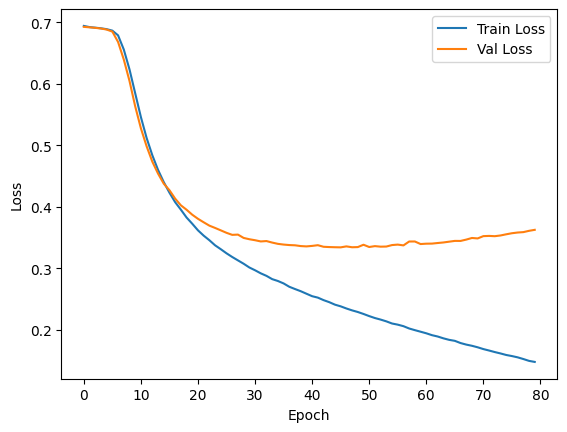

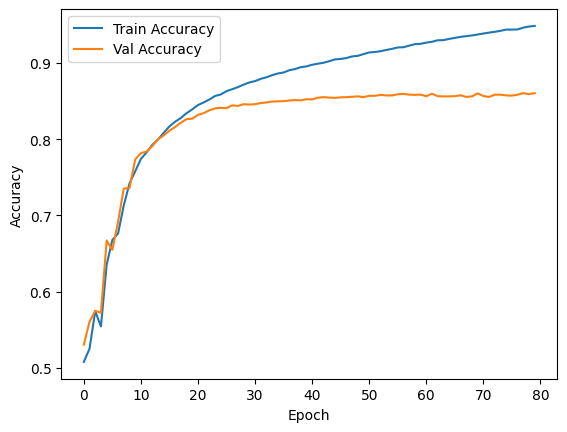

Test Accuracy: 0.8591


In [18]:
# Convert data to PyTorch tensors and move to GPU if available
x_train_tensor = torch.tensor(x_train).long().to(device)
y_train_tensor = torch.tensor(y_train.values).float().to(device)
x_val_tensor = torch.tensor(x_val).long().to(device)
y_val_tensor = torch.tensor(y_val.values).float().to(device)
x_test_tensor = torch.tensor(x_test).long().to(device)

# Create DataLoader for training and validation sets
train_dataset = TensorDataset(x_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=512, shuffle=True)
val_dataset = TensorDataset(x_val_tensor, y_val_tensor)
val_loader = DataLoader(val_dataset, batch_size=512)

# Hyperparameters
embedding_dim = 64
hidden_dim = 64
learning_rate = 0.0001
num_epochs = 80

# Instantiate the model and move it to GPU if available
model = RNNClassifier_b(frequentWord, embedding_dim, hidden_dim).to(device)

# Define loss function and optimizer
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Training loop
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

for epoch in range(num_epochs):
    start_time = time.time()  # Record start time for the epoch

    model.train()
    train_loss = 0.0
    correct_train = 0
    total_train = 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)  # Move batch to GPU
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * inputs.size(0)

        predicted = torch.round(outputs)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    train_loss /= len(train_loader.dataset)
    train_losses.append(train_loss)
    train_accuracy = correct_train / total_train
    train_accuracies.append(train_accuracy)

    model.eval()
    val_loss = 0.0
    correct_val = 0
    total_val = 0

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)  # Move batch to GPU
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * inputs.size(0)

            predicted = torch.round(outputs)
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()

    val_loss /= len(val_loader.dataset)
    val_losses.append(val_loss)
    val_accuracy = correct_val / total_val
    val_accuracies.append(val_accuracy)

    epoch_time = time.time() - start_time  # Calculate time taken for the epoch
    print(f'Epoch {epoch+1}/{num_epochs}, Time: {epoch_time:.2f}s, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, Val Accuracy: {val_accuracy:.4f}')

# Plotting train and validation losses
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plotting train and validation accuracies
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(val_accuracies, label='Val Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Evaluation on test set
model.eval()
with torch.no_grad():
    outputs = model(x_test_tensor)
    y_pred = torch.round(outputs).cpu().numpy()  # Move predictions to CPU for numpy conversion

# Calculate test accuracy
test_accuracy = np.mean(y_pred == y_test.values)
print(f'Test Accuracy: {test_accuracy:.4f}')

## L2 Regularization with weight decay of 1e-4

Epoch 1/80, Time: 5.35s, Train Loss: 0.6976, Val Loss: 0.6932, Train Accuracy: 0.4988, Val Accuracy: 0.4880
Epoch 2/80, Time: 0.36s, Train Loss: 0.6928, Val Loss: 0.6926, Train Accuracy: 0.5171, Val Accuracy: 0.5340
Epoch 3/80, Time: 0.37s, Train Loss: 0.6922, Val Loss: 0.6919, Train Accuracy: 0.5290, Val Accuracy: 0.5380
Epoch 4/80, Time: 4.66s, Train Loss: 0.6913, Val Loss: 0.6909, Train Accuracy: 0.5654, Val Accuracy: 0.5645
Epoch 5/80, Time: 0.36s, Train Loss: 0.6899, Val Loss: 0.6891, Train Accuracy: 0.5889, Val Accuracy: 0.6285
Epoch 6/80, Time: 4.73s, Train Loss: 0.6876, Val Loss: 0.6863, Train Accuracy: 0.6283, Val Accuracy: 0.6338
Epoch 7/80, Time: 0.37s, Train Loss: 0.6831, Val Loss: 0.6780, Train Accuracy: 0.6413, Val Accuracy: 0.6455
Epoch 8/80, Time: 0.36s, Train Loss: 0.6668, Val Loss: 0.6545, Train Accuracy: 0.6689, Val Accuracy: 0.6713
Epoch 9/80, Time: 4.62s, Train Loss: 0.6403, Val Loss: 0.6263, Train Accuracy: 0.6865, Val Accuracy: 0.6803
Epoch 10/80, Time: 0.61s, Tr

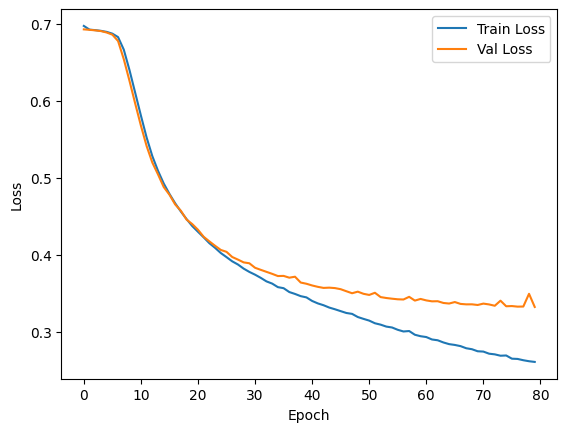

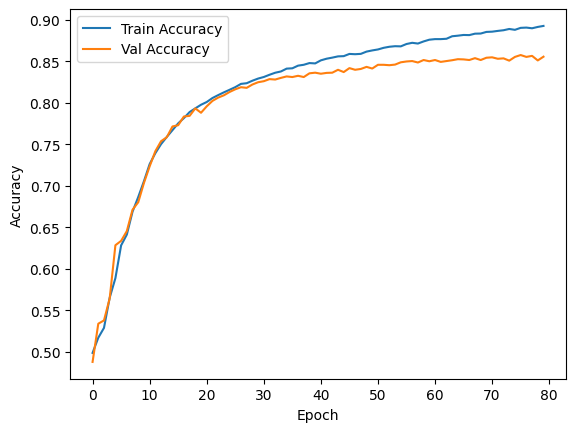

Test Accuracy: 0.8510


In [19]:
# Assuming you have x_train, y_train, x_val, y_val, x_test, y_test as your data
x_train_tensor = torch.tensor(x_train).long().to(device)
y_train_tensor = torch.tensor(y_train.values).float().to(device)
x_val_tensor = torch.tensor(x_val).long().to(device)
y_val_tensor = torch.tensor(y_val.values).float().to(device)
x_test_tensor = torch.tensor(x_test).long().to(device)

# Create DataLoader for training and validation sets
train_dataset = TensorDataset(x_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=512, shuffle=True)
val_dataset = TensorDataset(x_val_tensor, y_val_tensor)
val_loader = DataLoader(val_dataset, batch_size=512)

# Hyperparameters
embedding_dim = 64
hidden_dim = 64
learning_rate = 0.0001
num_epochs = 80

# Instantiate the model and move it to GPU if available
model = RNNClassifier_b(frequentWord, embedding_dim, hidden_dim).to(device)

# Define loss function and optimizer with weight decay
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-4)

# Training loop
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

for epoch in range(num_epochs):
    start_time = time.time()  # Record start time for the epoch

    model.train()
    train_loss = 0.0
    correct_train = 0
    total_train = 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)  # Move batch to GPU
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * inputs.size(0)

        predicted = torch.round(outputs)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    train_loss /= len(train_loader.dataset)
    train_losses.append(train_loss)
    train_accuracy = correct_train / total_train
    train_accuracies.append(train_accuracy)

    model.eval()
    val_loss = 0.0
    correct_val = 0
    total_val = 0

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)  # Move batch to GPU
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * inputs.size(0)

            predicted = torch.round(outputs)
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()

    val_loss /= len(val_loader.dataset)
    val_losses.append(val_loss)
    val_accuracy = correct_val / total_val
    val_accuracies.append(val_accuracy)

    epoch_time = time.time() - start_time  # Calculate time taken for the epoch
    print(f'Epoch {epoch+1}/{num_epochs}, Time: {epoch_time:.2f}s, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, Val Accuracy: {val_accuracy:.4f}')

# Plotting train and validation losses
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plotting train and validation accuracies
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(val_accuracies, label='Val Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Evaluation on test set
model.eval()
with torch.no_grad():
    outputs = model(x_test_tensor)
    y_pred = torch.round(outputs).cpu().numpy()  # Move predictions to CPU for numpy conversion

# Calculate test accuracy
test_accuracy = np.mean(y_pred == y_test.values)
print(f'Test Accuracy: {test_accuracy:.4f}')

## L2 Regularization with weight decay of 1e-3

Epoch 1/90, Time: 0.38s, Train Loss: 0.6951, Val Loss: 0.6932, Train Accuracy: 0.5000, Val Accuracy: 0.5000
Epoch 2/90, Time: 4.75s, Train Loss: 0.6927, Val Loss: 0.6924, Train Accuracy: 0.5000, Val Accuracy: 0.5005
Epoch 3/90, Time: 0.37s, Train Loss: 0.6916, Val Loss: 0.6912, Train Accuracy: 0.5188, Val Accuracy: 0.5152
Epoch 4/90, Time: 0.37s, Train Loss: 0.6901, Val Loss: 0.6895, Train Accuracy: 0.5681, Val Accuracy: 0.5767
Epoch 5/90, Time: 4.65s, Train Loss: 0.6878, Val Loss: 0.6869, Train Accuracy: 0.6055, Val Accuracy: 0.6358
Epoch 6/90, Time: 0.37s, Train Loss: 0.6845, Val Loss: 0.6832, Train Accuracy: 0.6562, Val Accuracy: 0.6455
Epoch 7/90, Time: 4.63s, Train Loss: 0.6793, Val Loss: 0.6765, Train Accuracy: 0.6753, Val Accuracy: 0.7065
Epoch 8/90, Time: 0.38s, Train Loss: 0.6686, Val Loss: 0.6585, Train Accuracy: 0.7215, Val Accuracy: 0.6825
Epoch 9/90, Time: 0.35s, Train Loss: 0.6419, Val Loss: 0.6266, Train Accuracy: 0.7137, Val Accuracy: 0.7095
Epoch 10/90, Time: 4.65s, Tr

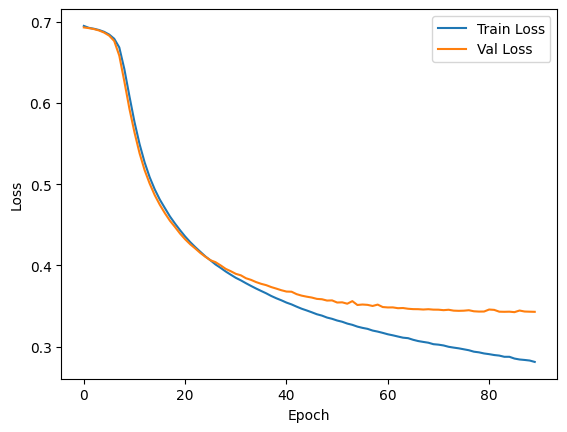

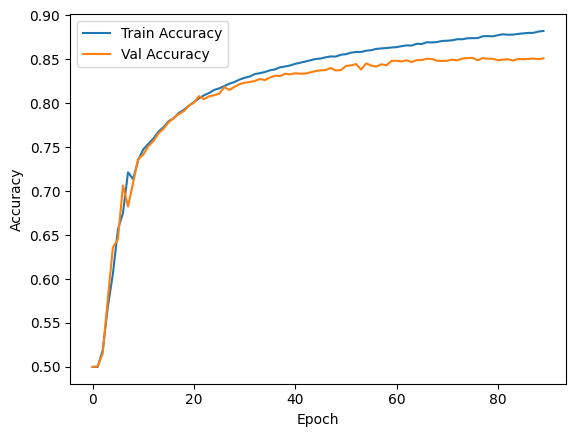

Test Accuracy: 0.8444


In [20]:
# Assuming you have x_train, y_train, x_val, y_val, x_test, y_test as your data
x_train_tensor = torch.tensor(x_train).long().to(device)
y_train_tensor = torch.tensor(y_train.values).float().to(device)
x_val_tensor = torch.tensor(x_val).long().to(device)
y_val_tensor = torch.tensor(y_val.values).float().to(device)
x_test_tensor = torch.tensor(x_test).long().to(device)

# Create DataLoader for training and validation sets
train_dataset = TensorDataset(x_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=512, shuffle=True)
val_dataset = TensorDataset(x_val_tensor, y_val_tensor)
val_loader = DataLoader(val_dataset, batch_size=512)

# Hyperparameters
embedding_dim = 64
hidden_dim = 64
learning_rate = 0.0001
num_epochs = 90

# Instantiate the model and move it to GPU if available
model = RNNClassifier_b(frequentWord, embedding_dim, hidden_dim).to(device)

# Define loss function and optimizer with weight decay
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-3)

# Training loop
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

for epoch in range(num_epochs):
    start_time = time.time()  # Record start time for the epoch

    model.train()
    train_loss = 0.0
    correct_train = 0
    total_train = 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)  # Move batch to GPU
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * inputs.size(0)

        predicted = torch.round(outputs)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    train_loss /= len(train_loader.dataset)
    train_losses.append(train_loss)
    train_accuracy = correct_train / total_train
    train_accuracies.append(train_accuracy)

    model.eval()
    val_loss = 0.0
    correct_val = 0
    total_val = 0

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)  # Move batch to GPU
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * inputs.size(0)

            predicted = torch.round(outputs)
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()

    val_loss /= len(val_loader.dataset)
    val_losses.append(val_loss)
    val_accuracy = correct_val / total_val
    val_accuracies.append(val_accuracy)

    epoch_time = time.time() - start_time  # Calculate time taken for the epoch
    print(f'Epoch {epoch+1}/{num_epochs}, Time: {epoch_time:.2f}s, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, Val Accuracy: {val_accuracy:.4f}')

# Plotting train and validation losses
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plotting train and validation accuracies
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(val_accuracies, label='Val Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Evaluation on test set
model.eval()
with torch.no_grad():
    outputs = model(x_test_tensor)
    y_pred = torch.round(outputs).cpu().numpy()  # Move predictions to CPU for numpy conversion

# Calculate test accuracy
test_accuracy = np.mean(y_pred == y_test.values)
print(f'Test Accuracy: {test_accuracy:.4f}')

## L2 Regularization with weight decay of 1e-2

Epoch 1/100, Time: 0.39s, Train Loss: 0.6931, Val Loss: 0.6930, Train Accuracy: 0.5003, Val Accuracy: 0.5080
Epoch 2/100, Time: 4.61s, Train Loss: 0.6929, Val Loss: 0.6927, Train Accuracy: 0.5169, Val Accuracy: 0.5202
Epoch 3/100, Time: 0.65s, Train Loss: 0.6925, Val Loss: 0.6922, Train Accuracy: 0.5334, Val Accuracy: 0.5400
Epoch 4/100, Time: 4.67s, Train Loss: 0.6918, Val Loss: 0.6915, Train Accuracy: 0.5611, Val Accuracy: 0.5565
Epoch 5/100, Time: 0.37s, Train Loss: 0.6909, Val Loss: 0.6904, Train Accuracy: 0.5812, Val Accuracy: 0.6118
Epoch 6/100, Time: 4.71s, Train Loss: 0.6895, Val Loss: 0.6888, Train Accuracy: 0.6253, Val Accuracy: 0.6468
Epoch 7/100, Time: 0.36s, Train Loss: 0.6876, Val Loss: 0.6865, Train Accuracy: 0.6595, Val Accuracy: 0.6743
Epoch 8/100, Time: 0.39s, Train Loss: 0.6848, Val Loss: 0.6832, Train Accuracy: 0.6781, Val Accuracy: 0.6887
Epoch 9/100, Time: 4.65s, Train Loss: 0.6812, Val Loss: 0.6793, Train Accuracy: 0.6855, Val Accuracy: 0.6957
Epoch 10/100, Time:

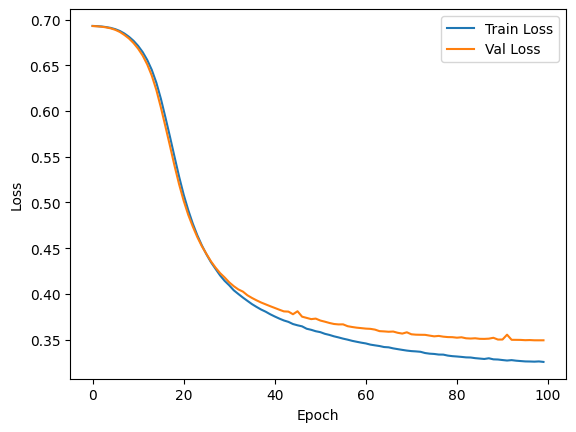

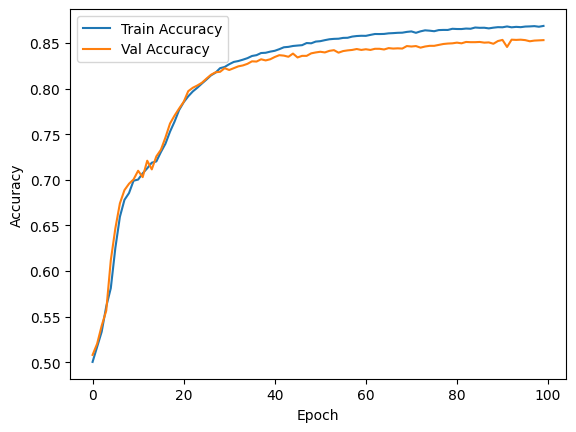

Test Accuracy: 0.8461


In [21]:
# Assuming you have x_train, y_train, x_val, y_val, x_test, y_test as your data
x_train_tensor = torch.tensor(x_train).long().to(device)
y_train_tensor = torch.tensor(y_train.values).float().to(device)
x_val_tensor = torch.tensor(x_val).long().to(device)
y_val_tensor = torch.tensor(y_val.values).float().to(device)
x_test_tensor = torch.tensor(x_test).long().to(device)

# Create DataLoader for training and validation sets
train_dataset = TensorDataset(x_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=512, shuffle=True)
val_dataset = TensorDataset(x_val_tensor, y_val_tensor)
val_loader = DataLoader(val_dataset, batch_size=512)

# Hyperparameters
embedding_dim = 64
hidden_dim = 64
learning_rate = 0.0001
num_epochs = 100

# Instantiate the model and move it to GPU if available
model = RNNClassifier_b(frequentWord, embedding_dim, hidden_dim).to(device)

# Define loss function and optimizer with weight decay
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-2)

# Training loop
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

for epoch in range(num_epochs):
    start_time = time.time()  # Record start time for the epoch

    model.train()
    train_loss = 0.0
    correct_train = 0
    total_train = 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)  # Move batch to GPU
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * inputs.size(0)

        predicted = torch.round(outputs)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    train_loss /= len(train_loader.dataset)
    train_losses.append(train_loss)
    train_accuracy = correct_train / total_train
    train_accuracies.append(train_accuracy)

    model.eval()
    val_loss = 0.0
    correct_val = 0
    total_val = 0

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)  # Move batch to GPU
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * inputs.size(0)

            predicted = torch.round(outputs)
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()

    val_loss /= len(val_loader.dataset)
    val_losses.append(val_loss)
    val_accuracy = correct_val / total_val
    val_accuracies.append(val_accuracy)

    epoch_time = time.time() - start_time  # Calculate time taken for the epoch
    print(f'Epoch {epoch+1}/{num_epochs}, Time: {epoch_time:.2f}s, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, Val Accuracy: {val_accuracy:.4f}')

# Plotting train and validation losses
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plotting train and validation accuracies
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(val_accuracies, label='Val Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Evaluation on test set
model.eval()
with torch.no_grad():
    outputs = model(x_test_tensor)
    y_pred = torch.round(outputs).cpu().numpy()  # Move predictions to CPU for numpy conversion

# Calculate test accuracy
test_accuracy = np.mean(y_pred == y_test.values)
print(f'Test Accuracy: {test_accuracy:.4f}')

## L2 Regularization with weight decay of 9e-3

Epoch 1/100, Time: 0.40s, Train Loss: 0.6933, Val Loss: 0.6931, Train Accuracy: 0.4990, Val Accuracy: 0.5040
Epoch 2/100, Time: 4.97s, Train Loss: 0.6931, Val Loss: 0.6931, Train Accuracy: 0.5074, Val Accuracy: 0.5015
Epoch 3/100, Time: 0.40s, Train Loss: 0.6929, Val Loss: 0.6929, Train Accuracy: 0.5121, Val Accuracy: 0.5168
Epoch 4/100, Time: 4.67s, Train Loss: 0.6927, Val Loss: 0.6926, Train Accuracy: 0.5260, Val Accuracy: 0.5270
Epoch 5/100, Time: 0.37s, Train Loss: 0.6922, Val Loss: 0.6921, Train Accuracy: 0.5549, Val Accuracy: 0.5625
Epoch 6/100, Time: 4.62s, Train Loss: 0.6916, Val Loss: 0.6913, Train Accuracy: 0.5732, Val Accuracy: 0.6078
Epoch 7/100, Time: 0.37s, Train Loss: 0.6905, Val Loss: 0.6899, Train Accuracy: 0.5971, Val Accuracy: 0.6152
Epoch 8/100, Time: 0.36s, Train Loss: 0.6889, Val Loss: 0.6881, Train Accuracy: 0.6532, Val Accuracy: 0.6763
Epoch 9/100, Time: 4.61s, Train Loss: 0.6866, Val Loss: 0.6851, Train Accuracy: 0.6839, Val Accuracy: 0.6910
Epoch 10/100, Time:

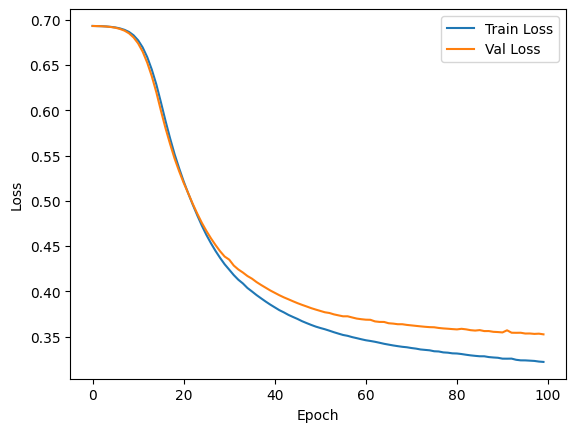

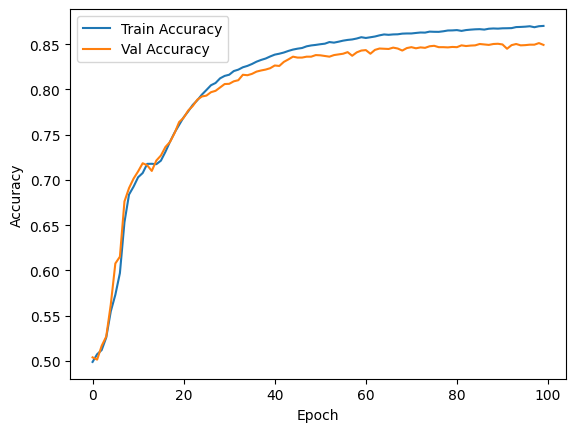

Test Accuracy: 0.8489


In [22]:
# Assuming you have x_train, y_train, x_val, y_val, x_test, y_test as your data
x_train_tensor = torch.tensor(x_train).long().to(device)
y_train_tensor = torch.tensor(y_train.values).float().to(device)
x_val_tensor = torch.tensor(x_val).long().to(device)
y_val_tensor = torch.tensor(y_val.values).float().to(device)
x_test_tensor = torch.tensor(x_test).long().to(device)

# Create DataLoader for training and validation sets
train_dataset = TensorDataset(x_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=512, shuffle=True)
val_dataset = TensorDataset(x_val_tensor, y_val_tensor)
val_loader = DataLoader(val_dataset, batch_size=512)

# Hyperparameters
embedding_dim = 64
hidden_dim = 64
learning_rate = 0.0001
num_epochs = 100

# Instantiate the model and move it to GPU if available
model = RNNClassifier_b(frequentWord, embedding_dim, hidden_dim).to(device)

# Define loss function and optimizer with weight decay
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=9e-3)

# Training loop
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

for epoch in range(num_epochs):
    start_time = time.time()  # Record start time for the epoch

    model.train()
    train_loss = 0.0
    correct_train = 0
    total_train = 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)  # Move batch to GPU
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * inputs.size(0)

        predicted = torch.round(outputs)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    train_loss /= len(train_loader.dataset)
    train_losses.append(train_loss)
    train_accuracy = correct_train / total_train
    train_accuracies.append(train_accuracy)

    model.eval()
    val_loss = 0.0
    correct_val = 0
    total_val = 0

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)  # Move batch to GPU
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * inputs.size(0)

            predicted = torch.round(outputs)
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()

    val_loss /= len(val_loader.dataset)
    val_losses.append(val_loss)
    val_accuracy = correct_val / total_val
    val_accuracies.append(val_accuracy)

    epoch_time = time.time() - start_time  # Calculate time taken for the epoch
    print(f'Epoch {epoch+1}/{num_epochs}, Time: {epoch_time:.2f}s, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, Val Accuracy: {val_accuracy:.4f}')

# Plotting train and validation losses
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plotting train and validation accuracies
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(val_accuracies, label='Val Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Evaluation on test set
model.eval()
with torch.no_grad():
    outputs = model(x_test_tensor)
    y_pred = torch.round(outputs).cpu().numpy()  # Move predictions to CPU for numpy conversion

# Calculate test accuracy
test_accuracy = np.mean(y_pred == y_test.values)
print(f'Test Accuracy: {test_accuracy:.4f}')

## L2 Regularization with weight decay of 8.9e-3
# Best Graph
## Hyperparameters
## L2 Regularization = 8.9e-3
## Batch Size = 512
## Learning Rate = 0.0001

Epoch 1/100, Time: 4.62s, Train Loss: 0.6929, Val Loss: 0.6928, Train Accuracy: 0.5110, Val Accuracy: 0.5228
Epoch 2/100, Time: 0.63s, Train Loss: 0.6925, Val Loss: 0.6924, Train Accuracy: 0.5257, Val Accuracy: 0.5208
Epoch 3/100, Time: 4.63s, Train Loss: 0.6920, Val Loss: 0.6918, Train Accuracy: 0.5441, Val Accuracy: 0.5515
Epoch 4/100, Time: 0.37s, Train Loss: 0.6912, Val Loss: 0.6909, Train Accuracy: 0.5610, Val Accuracy: 0.5813
Epoch 5/100, Time: 4.69s, Train Loss: 0.6901, Val Loss: 0.6896, Train Accuracy: 0.5901, Val Accuracy: 0.6025
Epoch 6/100, Time: 0.39s, Train Loss: 0.6885, Val Loss: 0.6878, Train Accuracy: 0.6186, Val Accuracy: 0.6242
Epoch 7/100, Time: 0.38s, Train Loss: 0.6862, Val Loss: 0.6851, Train Accuracy: 0.6368, Val Accuracy: 0.6420
Epoch 8/100, Time: 4.76s, Train Loss: 0.6830, Val Loss: 0.6815, Train Accuracy: 0.6600, Val Accuracy: 0.6577
Epoch 9/100, Time: 0.38s, Train Loss: 0.6790, Val Loss: 0.6770, Train Accuracy: 0.6705, Val Accuracy: 0.6733
Epoch 10/100, Time:

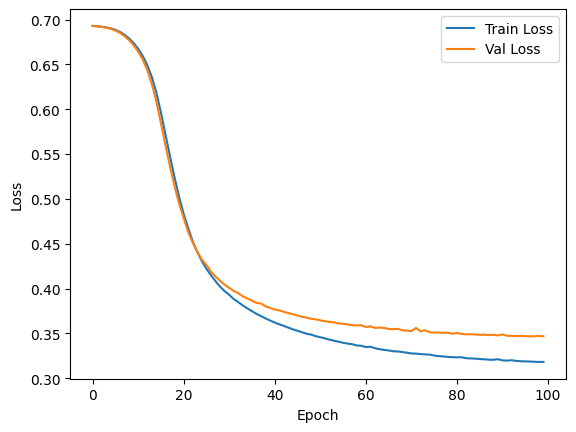

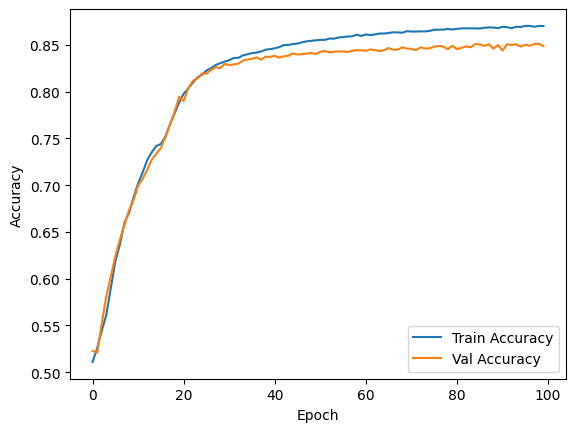

Test Accuracy: 0.8472


In [23]:
# Assuming you have x_train, y_train, x_val, y_val, x_test, y_test as your data
x_train_tensor = torch.tensor(x_train).long().to(device)
y_train_tensor = torch.tensor(y_train.values).float().to(device)
x_val_tensor = torch.tensor(x_val).long().to(device)
y_val_tensor = torch.tensor(y_val.values).float().to(device)
x_test_tensor = torch.tensor(x_test).long().to(device)

# Create DataLoader for training and validation sets
train_dataset = TensorDataset(x_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=512, shuffle=True)
val_dataset = TensorDataset(x_val_tensor, y_val_tensor)
val_loader = DataLoader(val_dataset, batch_size=512)

# Hyperparameters
embedding_dim = 64
hidden_dim = 64
learning_rate = 0.0001
num_epochs = 100

# Instantiate the model and move it to GPU if available
model = RNNClassifier_b(frequentWord, embedding_dim, hidden_dim).to(device)

# Define loss function and optimizer with weight decay
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=8.9e-3)

# Training loop
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

for epoch in range(num_epochs):
    start_time = time.time()  # Record start time for the epoch

    model.train()
    train_loss = 0.0
    correct_train = 0
    total_train = 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)  # Move batch to GPU
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * inputs.size(0)

        predicted = torch.round(outputs)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    train_loss /= len(train_loader.dataset)
    train_losses.append(train_loss)
    train_accuracy = correct_train / total_train
    train_accuracies.append(train_accuracy)

    model.eval()
    val_loss = 0.0
    correct_val = 0
    total_val = 0

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)  # Move batch to GPU
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * inputs.size(0)

            predicted = torch.round(outputs)
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()

    val_loss /= len(val_loader.dataset)
    val_losses.append(val_loss)
    val_accuracy = correct_val / total_val
    val_accuracies.append(val_accuracy)

    epoch_time = time.time() - start_time  # Calculate time taken for the epoch
    print(f'Epoch {epoch+1}/{num_epochs}, Time: {epoch_time:.2f}s, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, Val Accuracy: {val_accuracy:.4f}')

# Plotting train and validation losses
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plotting train and validation accuracies
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(val_accuracies, label='Val Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Evaluation on test set
model.eval()
with torch.no_grad():
    outputs = model(x_test_tensor)
    y_pred = torch.round(outputs).cpu().numpy()  # Move predictions to CPU for numpy conversion

# Calculate test accuracy
test_accuracy = np.mean(y_pred == y_test.values)
print(f'Test Accuracy: {test_accuracy:.4f}')

## L2 Regularization with weight decay of 7e-3

Epoch 1/100, Time: 4.71s, Train Loss: 0.6957, Val Loss: 0.6928, Train Accuracy: 0.5051, Val Accuracy: 0.5265
Epoch 2/100, Time: 0.37s, Train Loss: 0.6926, Val Loss: 0.6923, Train Accuracy: 0.5214, Val Accuracy: 0.5340
Epoch 3/100, Time: 4.88s, Train Loss: 0.6919, Val Loss: 0.6915, Train Accuracy: 0.5393, Val Accuracy: 0.5675
Epoch 4/100, Time: 0.37s, Train Loss: 0.6909, Val Loss: 0.6903, Train Accuracy: 0.5959, Val Accuracy: 0.6060
Epoch 5/100, Time: 0.37s, Train Loss: 0.6895, Val Loss: 0.6887, Train Accuracy: 0.6110, Val Accuracy: 0.5992
Epoch 6/100, Time: 4.69s, Train Loss: 0.6873, Val Loss: 0.6859, Train Accuracy: 0.6706, Val Accuracy: 0.6807
Epoch 7/100, Time: 0.38s, Train Loss: 0.6840, Val Loss: 0.6819, Train Accuracy: 0.6800, Val Accuracy: 0.7220
Epoch 8/100, Time: 0.36s, Train Loss: 0.6791, Val Loss: 0.6762, Train Accuracy: 0.7242, Val Accuracy: 0.7188
Epoch 9/100, Time: 4.64s, Train Loss: 0.6717, Val Loss: 0.6675, Train Accuracy: 0.7334, Val Accuracy: 0.7315
Epoch 10/100, Time:

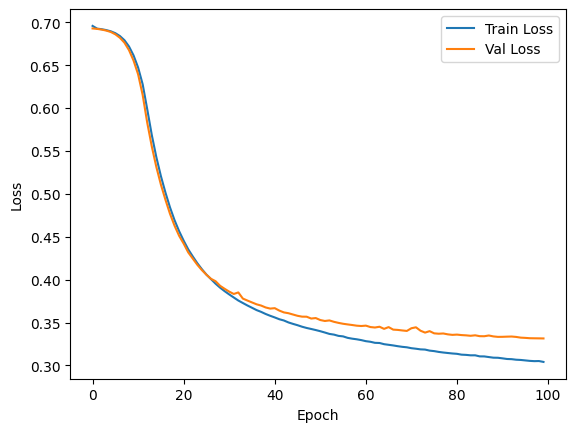

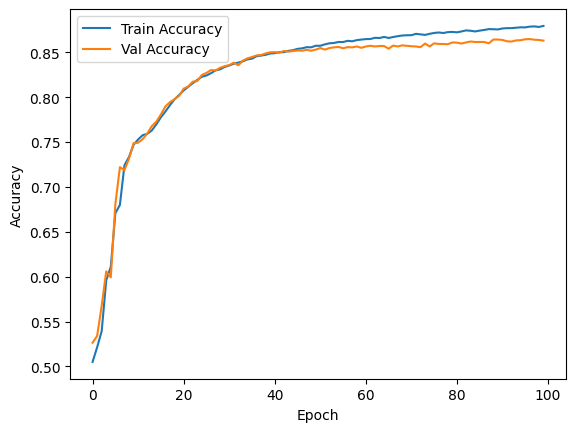

Test Accuracy: 0.8487


In [24]:
# Assuming you have x_train, y_train, x_val, y_val, x_test, y_test as your data
x_train_tensor = torch.tensor(x_train).long().to(device)
y_train_tensor = torch.tensor(y_train.values).float().to(device)
x_val_tensor = torch.tensor(x_val).long().to(device)
y_val_tensor = torch.tensor(y_val.values).float().to(device)
x_test_tensor = torch.tensor(x_test).long().to(device)

# Create DataLoader for training and validation sets
train_dataset = TensorDataset(x_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=512, shuffle=True)
val_dataset = TensorDataset(x_val_tensor, y_val_tensor)
val_loader = DataLoader(val_dataset, batch_size=512)

# Hyperparameters
embedding_dim = 64
hidden_dim = 64
learning_rate = 0.0001
num_epochs = 100

# Instantiate the model and move it to GPU if available
model = RNNClassifier_b(frequentWord, embedding_dim, hidden_dim).to(device)

# Define loss function and optimizer with weight decay
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=7e-3)

# Training loop
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

for epoch in range(num_epochs):
    start_time = time.time()  # Record start time for the epoch

    model.train()
    train_loss = 0.0
    correct_train = 0
    total_train = 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)  # Move batch to GPU
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * inputs.size(0)

        predicted = torch.round(outputs)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    train_loss /= len(train_loader.dataset)
    train_losses.append(train_loss)
    train_accuracy = correct_train / total_train
    train_accuracies.append(train_accuracy)

    model.eval()
    val_loss = 0.0
    correct_val = 0
    total_val = 0

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)  # Move batch to GPU
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * inputs.size(0)

            predicted = torch.round(outputs)
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()

    val_loss /= len(val_loader.dataset)
    val_losses.append(val_loss)
    val_accuracy = correct_val / total_val
    val_accuracies.append(val_accuracy)

    epoch_time = time.time() - start_time  # Calculate time taken for the epoch
    print(f'Epoch {epoch+1}/{num_epochs}, Time: {epoch_time:.2f}s, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, Val Accuracy: {val_accuracy:.4f}')

# Plotting train and validation losses
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plotting train and validation accuracies
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(val_accuracies, label='Val Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Evaluation on test set
model.eval()
with torch.no_grad():
    outputs = model(x_test_tensor)
    y_pred = torch.round(outputs).cpu().numpy()  # Move predictions to CPU for numpy conversion

# Calculate test accuracy
test_accuracy = np.mean(y_pred == y_test.values)
print(f'Test Accuracy: {test_accuracy:.4f}')

_____

____

____

## L2 Regularization with weight decay of 3e-3

Epoch 1/100, Time: 0.37s, Train Loss: 0.6930, Val Loss: 0.6925, Train Accuracy: 0.5134, Val Accuracy: 0.5308
Epoch 2/100, Time: 4.61s, Train Loss: 0.6923, Val Loss: 0.6918, Train Accuracy: 0.5333, Val Accuracy: 0.5607
Epoch 3/100, Time: 0.37s, Train Loss: 0.6915, Val Loss: 0.6909, Train Accuracy: 0.5629, Val Accuracy: 0.5867
Epoch 4/100, Time: 0.41s, Train Loss: 0.6902, Val Loss: 0.6895, Train Accuracy: 0.5894, Val Accuracy: 0.5988
Epoch 5/100, Time: 4.70s, Train Loss: 0.6884, Val Loss: 0.6874, Train Accuracy: 0.6406, Val Accuracy: 0.6522
Epoch 6/100, Time: 0.36s, Train Loss: 0.6858, Val Loss: 0.6844, Train Accuracy: 0.6711, Val Accuracy: 0.6703
Epoch 7/100, Time: 4.73s, Train Loss: 0.6820, Val Loss: 0.6799, Train Accuracy: 0.6939, Val Accuracy: 0.7000
Epoch 8/100, Time: 0.37s, Train Loss: 0.6761, Val Loss: 0.6727, Train Accuracy: 0.7241, Val Accuracy: 0.7127
Epoch 9/100, Time: 0.38s, Train Loss: 0.6669, Val Loss: 0.6616, Train Accuracy: 0.7331, Val Accuracy: 0.7378
Epoch 10/100, Time:

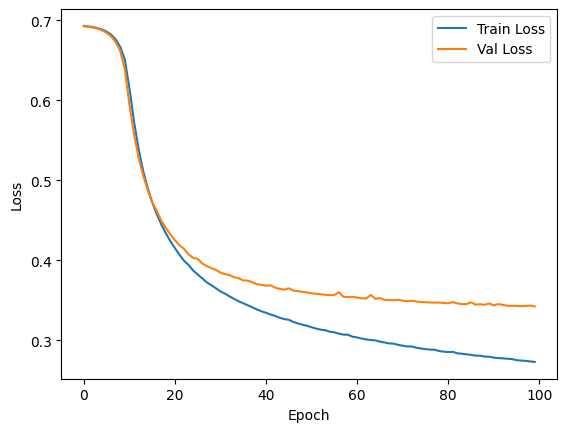

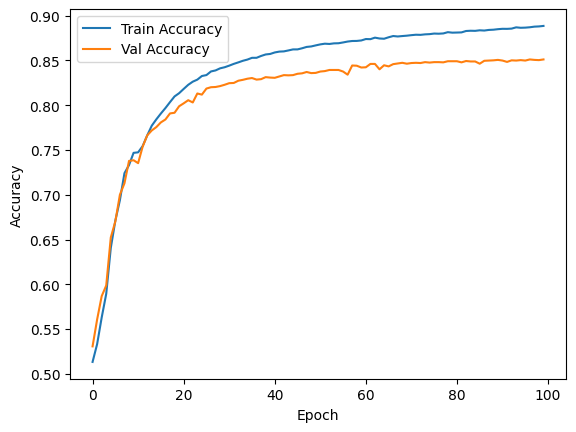

Test Accuracy: 0.8456


In [25]:
# Assuming you have x_train, y_train, x_val, y_val, x_test, y_test as your data
x_train_tensor = torch.tensor(x_train).long().to(device)
y_train_tensor = torch.tensor(y_train.values).float().to(device)
x_val_tensor = torch.tensor(x_val).long().to(device)
y_val_tensor = torch.tensor(y_val.values).float().to(device)
x_test_tensor = torch.tensor(x_test).long().to(device)

# Create DataLoader for training and validation sets
train_dataset = TensorDataset(x_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=512, shuffle=True)
val_dataset = TensorDataset(x_val_tensor, y_val_tensor)
val_loader = DataLoader(val_dataset, batch_size=512)

# Hyperparameters
embedding_dim = 64
hidden_dim = 64
learning_rate = 0.0001
num_epochs = 100

# Instantiate the model and move it to GPU if available
model = RNNClassifier_b(frequentWord, embedding_dim, hidden_dim).to(device)

# Define loss function and optimizer with weight decay
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=3e-3)

# Training loop
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

for epoch in range(num_epochs):
    start_time = time.time()  # Record start time for the epoch

    model.train()
    train_loss = 0.0
    correct_train = 0
    total_train = 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)  # Move batch to GPU
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * inputs.size(0)

        predicted = torch.round(outputs)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    train_loss /= len(train_loader.dataset)
    train_losses.append(train_loss)
    train_accuracy = correct_train / total_train
    train_accuracies.append(train_accuracy)

    model.eval()
    val_loss = 0.0
    correct_val = 0
    total_val = 0

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)  # Move batch to GPU
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * inputs.size(0)

            predicted = torch.round(outputs)
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()

    val_loss /= len(val_loader.dataset)
    val_losses.append(val_loss)
    val_accuracy = correct_val / total_val
    val_accuracies.append(val_accuracy)

    epoch_time = time.time() - start_time  # Calculate time taken for the epoch
    print(f'Epoch {epoch+1}/{num_epochs}, Time: {epoch_time:.2f}s, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, Val Accuracy: {val_accuracy:.4f}')

# Plotting train and validation losses
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plotting train and validation accuracies
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(val_accuracies, label='Val Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Evaluation on test set
model.eval()
with torch.no_grad():
    outputs = model(x_test_tensor)
    y_pred = torch.round(outputs).cpu().numpy()  # Move predictions to CPU for numpy conversion

# Calculate test accuracy
test_accuracy = np.mean(y_pred == y_test.values)
print(f'Test Accuracy: {test_accuracy:.4f}')

## L2 Regularization with weight decay of 5e-3

Epoch 1/100, Time: 0.41s, Train Loss: 0.6932, Val Loss: 0.6930, Train Accuracy: 0.5055, Val Accuracy: 0.5002
Epoch 2/100, Time: 4.79s, Train Loss: 0.6929, Val Loss: 0.6927, Train Accuracy: 0.5146, Val Accuracy: 0.5165
Epoch 3/100, Time: 0.36s, Train Loss: 0.6925, Val Loss: 0.6922, Train Accuracy: 0.5346, Val Accuracy: 0.5425
Epoch 4/100, Time: 4.80s, Train Loss: 0.6919, Val Loss: 0.6915, Train Accuracy: 0.5580, Val Accuracy: 0.5723
Epoch 5/100, Time: 0.37s, Train Loss: 0.6911, Val Loss: 0.6905, Train Accuracy: 0.5672, Val Accuracy: 0.6010
Epoch 6/100, Time: 4.89s, Train Loss: 0.6897, Val Loss: 0.6889, Train Accuracy: 0.6163, Val Accuracy: 0.5923
Epoch 7/100, Time: 0.38s, Train Loss: 0.6878, Val Loss: 0.6865, Train Accuracy: 0.6477, Val Accuracy: 0.6773
Epoch 8/100, Time: 0.37s, Train Loss: 0.6847, Val Loss: 0.6824, Train Accuracy: 0.6974, Val Accuracy: 0.7013
Epoch 9/100, Time: 4.73s, Train Loss: 0.6789, Val Loss: 0.6748, Train Accuracy: 0.7228, Val Accuracy: 0.7398
Epoch 10/100, Time:

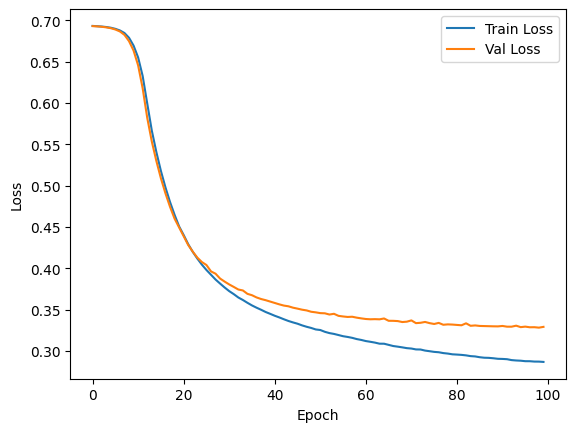

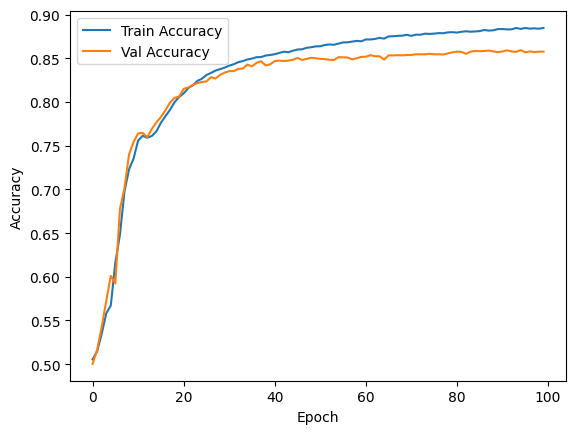

Test Accuracy: 0.8506


In [26]:
# Assuming you have x_train, y_train, x_val, y_val, x_test, y_test as your data
x_train_tensor = torch.tensor(x_train).long().to(device)
y_train_tensor = torch.tensor(y_train.values).float().to(device)
x_val_tensor = torch.tensor(x_val).long().to(device)
y_val_tensor = torch.tensor(y_val.values).float().to(device)
x_test_tensor = torch.tensor(x_test).long().to(device)

# Create DataLoader for training and validation sets
train_dataset = TensorDataset(x_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=512, shuffle=True)
val_dataset = TensorDataset(x_val_tensor, y_val_tensor)
val_loader = DataLoader(val_dataset, batch_size=512)

# Hyperparameters
embedding_dim = 64
hidden_dim = 64
learning_rate = 0.0001
num_epochs = 100

# Instantiate the model and move it to GPU if available
model = RNNClassifier_b(frequentWord, embedding_dim, hidden_dim).to(device)

# Define loss function and optimizer with weight decay
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=5e-3)

# Training loop
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

for epoch in range(num_epochs):
    start_time = time.time()  # Record start time for the epoch

    model.train()
    train_loss = 0.0
    correct_train = 0
    total_train = 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)  # Move batch to GPU
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * inputs.size(0)

        predicted = torch.round(outputs)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    train_loss /= len(train_loader.dataset)
    train_losses.append(train_loss)
    train_accuracy = correct_train / total_train
    train_accuracies.append(train_accuracy)

    model.eval()
    val_loss = 0.0
    correct_val = 0
    total_val = 0

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)  # Move batch to GPU
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * inputs.size(0)

            predicted = torch.round(outputs)
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()

    val_loss /= len(val_loader.dataset)
    val_losses.append(val_loss)
    val_accuracy = correct_val / total_val
    val_accuracies.append(val_accuracy)

    epoch_time = time.time() - start_time  # Calculate time taken for the epoch
    print(f'Epoch {epoch+1}/{num_epochs}, Time: {epoch_time:.2f}s, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, Val Accuracy: {val_accuracy:.4f}')

# Plotting train and validation losses
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plotting train and validation accuracies
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(val_accuracies, label='Val Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Evaluation on test set
model.eval()
with torch.no_grad():
    outputs = model(x_test_tensor)
    y_pred = torch.round(outputs).cpu().numpy()  # Move predictions to CPU for numpy conversion

# Calculate test accuracy
test_accuracy = np.mean(y_pred == y_test.values)
print(f'Test Accuracy: {test_accuracy:.4f}')

In [27]:
## conda install nomkl